In [4]:
import pandas as pd
import numpy as np 
import itertools
from scipy.stats import skew, kurtosis
from scipy.signal import savgol_filter

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor

import os
import time
import warnings
warnings.filterwarnings("ignore") 
import numpy as np
import pandas as pd
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Convolution1D, MaxPooling1D, Flatten,  Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

np.random.seed(7)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
df = pd.read_csv('final_df_v3.csv')

In [6]:
df['dengue-sg'] = df['rate'] * 1000000

In [7]:
cols = ['dengue-sg','rainfall-admiralty','rainfall-admiralty-west','rainfall-ang-mo-kio','rainfall-boon-lay-east',
        'rainfall-boon-lay-west','rainfall-botanic-garden','rainfall-buangkok','rainfall-bukit-panjang',
        'rainfall-bukit-timah','rainfall-buona-vista','rainfall-chai-chee','rainfall-changi',
        'rainfall-choa-chu-kang-central','rainfall-choa-chu-kang-south','rainfall-choa-chu-kang-west',
        'rainfall-clementi','rainfall-dhoby-ghaut','rainfall-east-coast-parkway','rainfall-jurong-east',
        'rainfall-jurong-north','rainfall-jurong-island','rainfall-jurong-pier','rainfall-kampong-bahru',
        'rainfall-kent-ridge','rainfall-khatib','rainfall-kranji-reservoir','rainfall-lim-chu-kang',
        'rainfall-lower-peirce-reservoir','rainfall-macritchie-reservoir','rainfall-mandai',
        'rainfall-marina-barrage','rainfall-marine-parade','rainfall-newton','rainfall-nicoll-highway',
        'rainfall-pasir-panjang','rainfall-pasir-ris-central','rainfall-pasir-ris-west','rainfall-paya-lebar',
        'rainfall-pulau-ubin','rainfall-punggol','rainfall-queenstown','rainfall-seletar','rainfall-semakau-island',
        'rainfall-sembawang','rainfall-sentosa-island','rainfall-serangoon','rainfall-serangoon-north','rainfall-simei',
        'rainfall-somerset-road','rainfall-tai-seng','rainfall-tanjong-katong','rainfall-tanjong-pagar','rainfall-tengah',
        'rainfall-toa-payoh','rainfall-tuas','rainfall-tuas-south','rainfall-tuas-west','rainfall-ulu-pandan',
        'rainfall-upper-peirce-reservoir','rainfall-upper-thomson','rainfall-whampoa']

In [8]:
df = df[cols]

In [9]:
def calc_avg(row):
  cols = list(df.columns[1:])
  all_rows = [row[x] for x in cols if not pd.isna(row[x])]
  return np.average(all_rows)

def calc_skew(row):
  cols = list(df.columns[1:])
  all_rows = [row[x] for x in cols if not pd.isna(row[x])]
  return skew(all_rows)

def calc_kurt(row):
  cols = list(df.columns[1:])
  all_rows = [row[x] for x in cols if not pd.isna(row[x])]
  return kurtosis(all_rows)

def calc_min(row):
  cols = list(df.columns[1:])
  all_rows = [row[x] for x in cols if not pd.isna(row[x])]
  return min(all_rows)

def calc_max(row):
  cols = list(df.columns[1:])
  all_rows = [row[x] for x in cols if not pd.isna(row[x])]
  return max(all_rows)

In [10]:
# df = df.drop(columns=problem)
df['skewness'] = df.apply(calc_skew, axis=1)
df['kurtosis'] = df.apply(calc_kurt, axis=1)
df['average'] = df.apply(calc_avg, axis=1)
df['max'] = df.apply(calc_max, axis=1)

In [62]:
df_y = df.iloc[:,0]
df_special = df[['skewness','kurtosis','average','max']]

In [70]:
y = df_y[17:].values
# X_1 = df_X_rain[10:df_X_rain.shape[0]-8]
X_2 = [df_special.values[start:start + 10] for start in range(0, df_special.values.shape[0] - 17)]
X_2 = [list(itertools.chain.from_iterable(i)) for i in X_2]
X_3 = [df_y.values[start:start + 10] for start in range(0, df_y.values.shape[0] - 17)]
# X_3 = [list(itertools.chain.from_iterable(i)) for i in X_3]
X = [list(a)+ list(b) for a,b in zip(X_2,X_3)]

In [77]:
X_train = X[:700]
y_train = y[:700]
X_test = X[700:]
y_test = y[700:]

In [78]:
model = XGBRegressor(eval_metric='rmse', min_child_weight = 5, random_state=42, learning_rate=0.02, n_estimators=600, objective="reg:squarederror", verbose=1)

params = {'penalty':['none','l1','l2','elasticnet'],
         'alpha':[5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1],
         'gamma': [0, 0.5, 1, 1.5, 2, 5],
         'max_iter' : [2, 5, 10],
         'subsample': [0.33, 0.67, 0.8],
         'colsample_bytree': [0.33, 0.67, 1.0],
         'max_depth': [3, 4, 5]
        }
gs = RandomizedSearchCV(estimator=model,
                 param_distributions=params,
                 scoring='neg_mean_squared_error',
                 n_jobs=1,
                 cv=5,
                 verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005, score=-226.124, total=   1.8s
[CV] subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005, score=-447.866, total=   1.1s
[CV] subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV]  subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005, score=-513.436, total=   1.3s
[CV] subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005 
[CV]  subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005, score=-84.020, total=   1.2s
[CV] subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005 
[CV]  subsample=0.33, penalty=l2, max_iter=2, max_depth=3, gamma=2, colsample_bytree=1.0, alpha=0.005, score=-497.505, total=   1.2s
[CV] subsample=0.33, penalty=l1, max_iter=10, max_depth=5, gamma=5, colsample_bytree=0.33, alpha=0.001 
[CV]  subsample=0.33, penalty=l1, max_iter=10, max_depth=5, gamma=5, colsample_bytree=0.33, alpha=0.001, score=-197.980, total=   1.0s
[CV] subsample=0.33, penalty=l1, max_iter=10, max_depth=5, gamma=5, colsample_bytree=0.33, alpha=0.001 
[CV]  subsample=0.33, penalty=l1, max_iter=10, max_dept

[CV]  subsample=0.67, penalty=l1, max_iter=5, max_depth=3, gamma=1, colsample_bytree=1.0, alpha=0.05, score=-505.476, total=   3.5s
[CV] subsample=0.67, penalty=l1, max_iter=5, max_depth=3, gamma=1, colsample_bytree=1.0, alpha=0.05 
[CV]  subsample=0.67, penalty=l1, max_iter=5, max_depth=3, gamma=1, colsample_bytree=1.0, alpha=0.05, score=-86.415, total=   3.4s
[CV] subsample=0.67, penalty=l1, max_iter=5, max_depth=3, gamma=1, colsample_bytree=1.0, alpha=0.05 
[CV]  subsample=0.67, penalty=l1, max_iter=5, max_depth=3, gamma=1, colsample_bytree=1.0, alpha=0.05, score=-516.802, total=   3.3s
[CV] subsample=0.8, penalty=elasticnet, max_iter=10, max_depth=5, gamma=5, colsample_bytree=0.67, alpha=0.001 
[CV]  subsample=0.8, penalty=elasticnet, max_iter=10, max_depth=5, gamma=5, colsample_bytree=0.67, alpha=0.001, score=-188.150, total=   3.9s
[CV] subsample=0.8, penalty=elasticnet, max_iter=10, max_depth=5, gamma=5, colsample_bytree=0.67, alpha=0.001 
[CV]  subsample=0.8, penalty=elasticnet

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          eval_metric='rmse', gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.02, max_delta_step=0,
                                          max_depth=3, min_child_weight=5,
                                          missing=None, n_estimators=600,
                                          n_jobs=1, nthread=None,
                                          objective='r...
                   param_distributions={'alpha': [0.0005, 0.001, 0.002, 0.005,
                                                  0.01, 0.02, 0.05, 0.1],
                                    

XGBRegressor(alpha=0.05, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, eval_metric='rmse',
             gamma=1, importance_type='gain', learning_rate=0.02,
             max_delta_step=0, max_depth=3, max_iter=5, min_child_weight=5,
             missing=None, n_estimators=600, n_jobs=1, nthread=None,
             objective='reg:squarederror', penalty='l1', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.67, verbose=1, verbosity=1)

In [79]:
gs.best_params_

{'subsample': 0.67,
 'penalty': 'l1',
 'max_iter': 5,
 'max_depth': 3,
 'gamma': 1,
 'colsample_bytree': 1.0,
 'alpha': 0.05}

In [117]:
res


,pred,true_value,diff
0,42.958897,81.679342,38.720445
1,46.062164,81.123700,35.061536
2,41.684711,69.270009,27.585297
3,44.363121,91.680894,47.317773
4,56.277157,84.827979,28.550822
5,58.559010,74.455999,15.896989
6,71.209511,82.234984,11.025473
7,75.426003,67.603084,-7.822919
8,72.201439,68.899581,-3.301858
9,76.285736,64.269233,-12.016503


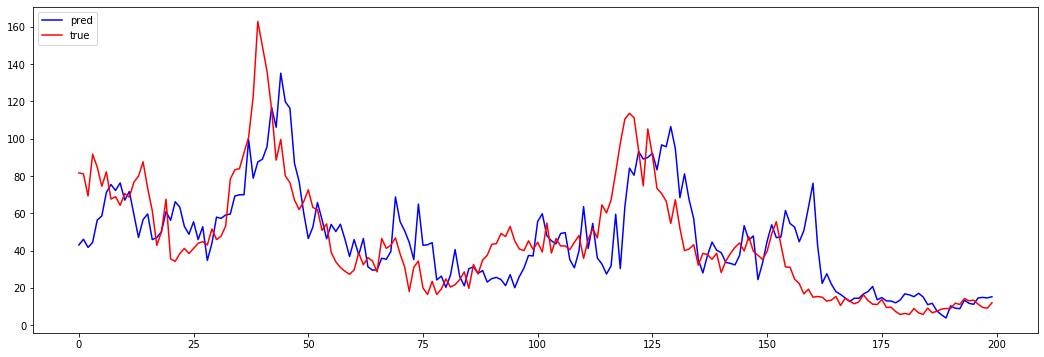

In [106]:
res = pd.DataFrame(gs.predict(X_test[:200]), columns=['pred'])
res['true_value'] = y_test[:200]
res['diff'] = res['true_value'] - res['pred']
plt.figure(figsize=(18,6))
plt.plot(res['pred'],'b',label='pred')
plt.plot(res['true_value'],'r',label='true')
plt.legend(loc='upper left')
# plt.savefig('testplot.png')

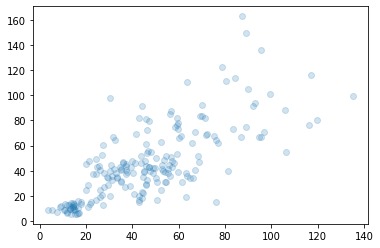

In [107]:
plt.scatter(res['pred'], res['true_value'], alpha=0.2)

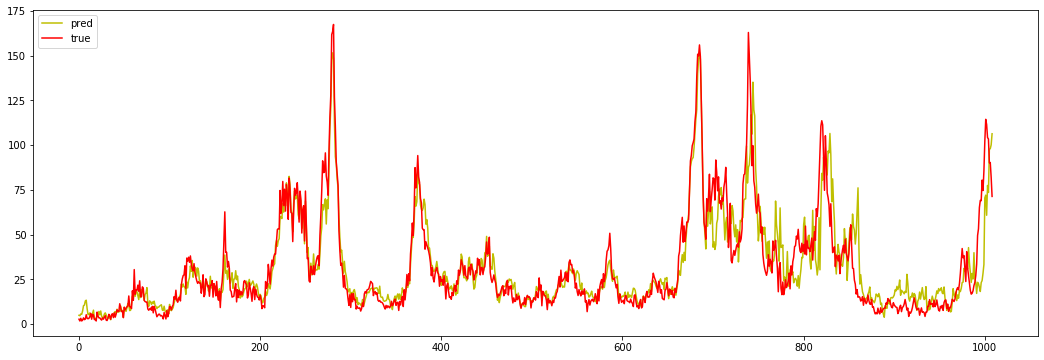

In [108]:
aa = pd.DataFrame(gs.predict(X), columns=['pred'])
aa['true_value'] = y

plt.figure(figsize=(18,6))
plt.plot(aa['pred'],'y', label='pred')
plt.plot(aa['true_value'],'r',label='true')
# plt.plot(savgol_filter(aa['pred'], 25, 7),'g',label='smooth_pred')
plt.legend(loc='upper left')
plt.show()
# plt.savefig('true_no_shuffle.png')

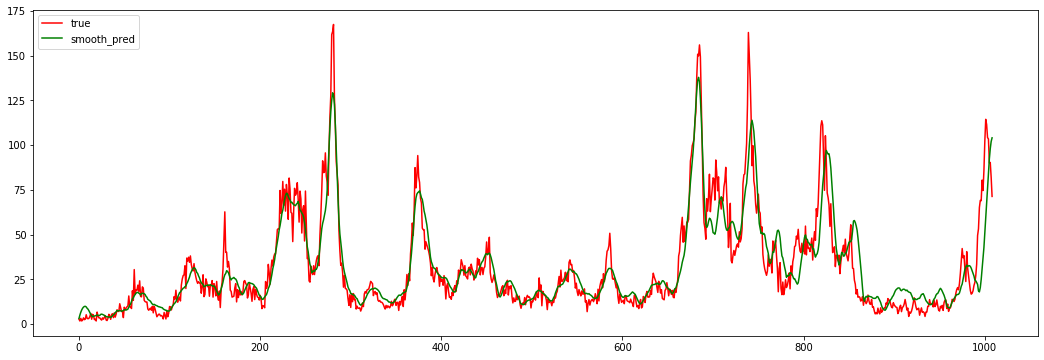

In [109]:
aa = pd.DataFrame(gs.predict(X), columns=['pred'])
aa['true_value'] = y

plt.figure(figsize=(18,6))
# plt.plot(aa['pred'],'b', label='pred')
plt.plot(aa['true_value'],'r',label='true')
## Smoothening ##
plt.plot(savgol_filter(aa['pred'], 15, 3),'g',label='smooth_pred')
plt.legend(loc='upper left')
plt.show()
# plt.savefig('true_no_shuffle.png')

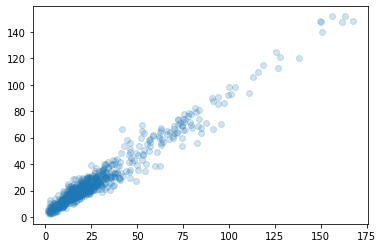

In [110]:
plt.scatter(y_train, gs.predict(X_train), alpha=0.2)

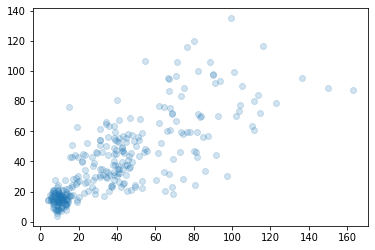

In [111]:
plt.scatter(y_test, gs.predict(X_test), alpha=0.2)

In [113]:
pred = gs.predict(X_train)
print('\n\nRMSE = ' + str(np.sqrt(mean_squared_error(y_train, pred))))

In [114]:
pred = gs.predict(X_test)
print('\n\nRMSE = ' + str(np.sqrt(mean_squared_error(y_test, pred))))

# TODO

### Use past weeks data

### Use difference instead

### Use neighbor data